### Problem statement
Create a machine learning model to forecast the fuel prices for the service stations in the Rhein-Neckar district based on 
the tanker König dataset.
#### Dataset
The dataset is published on the public website “Tankerkönig“ (http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided. 

We use the stations and prices data within this website only for blog posting and demonstration
purpose. For non-commercial use the data is availble with the following license agreement (https://creativecommons.org/licenses/by-nc-sa/4.0/)

### <ins> Part 1 Data Preparation </ins>

#### Import the requied python packages

In [1]:
import hana_ml
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np
import geopandas

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

#### Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

#### Load station data from "Tankerkönig" csv file and create HANA db table

In [4]:
# load gas station data from csv
stations_pd = pd.read_csv('./datasets/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

In [5]:
# create hana dataframe/DB table from pandas dataframe
stations_hdf = create_dataframe_from_pandas(
        conn,
        stations_pd,
        schema='DEMO_GASSTATION_DATA',
        table_name="GAS_STATIONS",
        force=True,
        replace=True,
        drop_exist_tab=False,
        geo_cols=[("longitude", "latitude")],
    )

100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


In [6]:
print("There are", stations_hdf.count(), "service stations in Germany")

There are 15442 service stations in Germany


In [7]:
# create dataframe from shapefile for Baden-Württemberg
regions_hdf = create_dataframe_from_shapefile(
  connection_context=conn,
  shp_file='./datasets/OD_AX_Gebiet_Kreis/AX_Gebiet_Kreis.shp',
  srid=25832,
  schema='DEMO_GASSTATION_DATA',
  table_name="BW_SHAPEFILE")

In [8]:
# filter service stations in Germany to those within the polygon of "Rhein-Neckar-Kreis" 
stations_rnk_hdf = stations_hdf.join(regions_hdf, 
       '"longitude_latitude_GEO".st_transform(25832).st_intersects(SHAPE)=1').filter("\"Name\"='Rhein-Neckar-Kreis'")

In [9]:
# number of service stations in Rhein-Neckar-Kreis
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count())

Number of Serice Stations in the Rhein-Neckar area 111


In [10]:
# optional -- needed only for visualization
# filter service stations in Germany to those NOT within the polygon of "Rhein-Neckar-Kreis" 
stations_bw_hdf = stations_hdf.join(regions_hdf, '"longitude_latitude_GEO".st_transform(25832).st_intersects(SHAPE)=1').filter("\"Name\"!='Rhein-Neckar-Kreis'")

In [11]:
# number of service stations in Baden-Württemberg, excluding the Rhein-Neckar-Kreis
print("Number of Serice Stations in Baden-Württemberg, excluding Rhein-Neckar area",stations_bw_hdf.count())

Number of Serice Stations in Baden-Württemberg, excluding Rhein-Neckar area 1899


#### Visualization  - optional 

In [12]:
# optional -- needed only for visualization
# loads the data from the DB into the python client
# very slow - takes a long time :-(
stations_rnk_pd = stations_rnk_hdf.collect()
stations_bw_pd = stations_bw_hdf.collect()

In [13]:
# prepare plot
stations_rnk_geopands = geopandas.GeoDataFrame(
    stations_rnk_pd, geometry=geopandas.points_from_xy(stations_rnk_pd.longitude, stations_rnk_pd.latitude))
stations_bw_geopands = geopandas.GeoDataFrame(
    stations_bw_pd, geometry=geopandas.points_from_xy(stations_bw_pd.longitude, stations_bw_pd.latitude))

In [14]:
# read shape-file into geopandas
bw = gpd.read_file('./datasets/OD_AX_Gebiet_Kreis/AX_Gebiet_Kreis.shp', )

In [15]:
bw_4326 = bw.to_crs(epsg=4326)

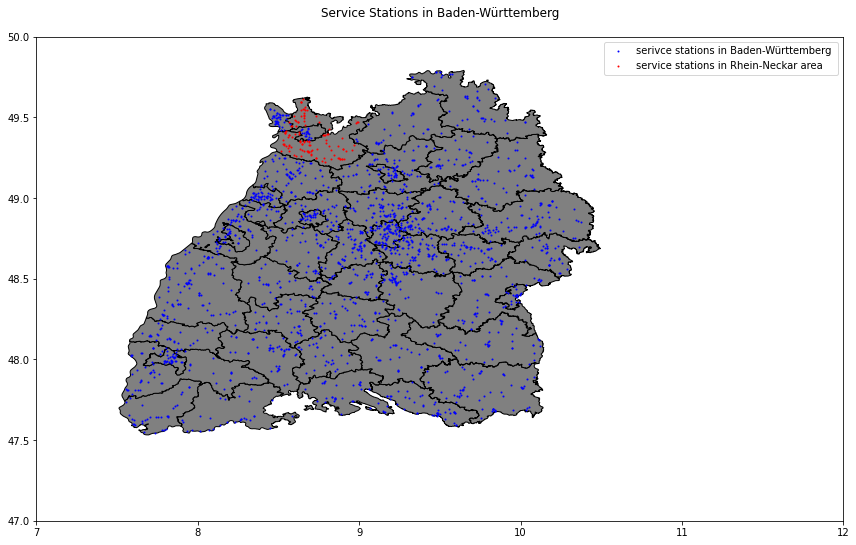

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((7,12))
ax.set_ylim((47,50))
bw_4326.plot(ax=ax, facecolor='Grey', edgecolor='k')
stations_bw_geopands.plot(ax=ax, marker='.',  color='blue', markersize=4, label='serivce stations in Baden-Württemberg ')
stations_rnk_geopands.plot(ax=ax, marker='.',  color='red', markersize=4, label='service stations in Rhein-Neckar area')
ax.legend()
ax.set_title('Service Stations in Baden-Württemberg', pad=20)
fig = ax.get_figure()
fig.tight_layout()

####  Analysis of the gas price dataset and creation of train and test datasets

Prerequisite: the fuel price records for the currenty year is loaded into a HANA DB table. Due to the size of the dataset, this is not inclued in the git repo. We only provide the resulting datasets for training, testing and the corresponding ground truth. Those dataset are small enough to be included in the git repository.


In [17]:
# create hana dataframe including all gas prices in Germany in 2022
train_all_hdf = conn.sql('select * from "DEMO_GASSTATION_DATA"."GAS_PRICES"')

In [18]:
print("There are", train_all_hdf.count(), "records in the dataset")

There are 56719236 records in the dataset


In [19]:
train_all_hdf.head(3).collect()

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2022-04-05 20:23:08,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999,1.999,1.939,1,1,1
1,2022-04-08 06:04:09,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999,1.999,1.939,1,1,1
2,2022-04-15 10:54:09,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999,1.999,1.939,1,1,1


In [20]:
# Since the dataset contains the prices for all the service stations in Germany, 
# we filter out the records for the gas prices for the service stations in Rhein-Neckar area only

train_rnk_hdf = train_all_hdf.alias('L').join(stations_rnk_hdf.alias('R'), 'L."station_uuid" = R."uuid"', select = [
    ('L."date"', 'date'),
    ('L."station_uuid"', 'station_uuid'),
    ('L."e5"', 'e5')
])

In [21]:
# performs the join on the database (defined above)
print("The dataset for the fuel prices for the service stations in Rhein-Neckar area contains",
     train_rnk_hdf.count(), "records")

The dataset for the fuel prices for the service stations in Rhein-Neckar area contains 372488 records


In [22]:
print( "The dataset covers the time period starting from: ")
print( train_all_hdf.sort('date').select('date').head(1).collect())

The dataset covers the time period starting from: 
                 date
0 2022-01-01 00:00:09


In [23]:
print( "... and ends at: ")
print( train_all_hdf.sort('date', desc=True).select('date').head(1).collect())

... and ends at: 
                 date
0 2022-06-21 23:59:10


#### Create CSVs for train, test and ground truth

In [24]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-06-14
train_rnk_trunc_hdf  = train_rnk_hdf.filter('"date" < \'2022-06-14 00:00:00.000\'')

In [25]:
# ground truth
test_groundtruth_rnk_hdf  = train_rnk_hdf.filter('"date" >= \'2022-06-14 00:00:00.000\'')

In [26]:
# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

In [27]:
test_groundtruth_rnk_hdf.head(3).collect()

,date,station_uuid,e5
0,2022-06-17 09:31:07,e1e4230d-98d0-433b-ad28-bf673862592f,2.019
1,2022-06-18 07:01:08,66f17d7a-2572-4c7a-81a3-91da096629cd,2.029
2,2022-06-18 07:01:08,c0bc562d-d77f-440e-9182-57654145275c,2.009


In [ ]:
# create csv files
test_gt_rnk_pd = test_groundtruth_rnk_hdf.collect()
test_gt_rnk_pd.to_csv('test_groundtruth.csv')

test_rnk_pd = test_rnk_hdf.collect()
test_rnk_pd.to_csv('test_rnk.csv')

train_rnk_pd = train_rnk_trunc_hdf.collect()
train_rnk_pd.to_csv('train_rnk.csv')